<a href="https://colab.research.google.com/github/prernakukreja5/Satellite_imagery_housing_price_prediction/blob/main/data_fetcher_preprocessing_CNN_grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import requests
import os
from time import sleep

MAPBOX_TOKEN = "pk.eyJ1IjoicHJlcm5hMDUiLCJhIjoiY21qcG1oYWwzM2QwaDNkczUwdWNpNnRiMyJ9.0aSTgqoXKv-uUnqLIMcIIw"
STYLE = "mapbox/satellite-v9"
ZOOM = 16
IMG_SIZE = "400x400"
SAVE_DIR = "satellite_images"

os.makedirs(SAVE_DIR, exist_ok=True)

locations = [
    (1, 28.6139, 77.2090),  # Delhi
    (2, 19.0760, 72.8777),  # Mumbai
    (3, 12.9716, 77.5946)   # Bangalore
]

for idx, lat, lon in locations:
    url = (
        f"https://api.mapbox.com/styles/v1/{STYLE}/static/"
        f"{lon},{lat},{ZOOM}/{IMG_SIZE}"
        f"?access_token={MAPBOX_TOKEN}"
    )

    r = requests.get(url)

    if r.status_code == 200:
        path = f"{SAVE_DIR}/img_{idx}.png"
        with open(path, "wb") as f:
            f.write(r.content)
        print("Saved", path)
    else:
        print("Error", r.status_code, r.text)

    sleep(0.2)



Saved satellite_images/img_1.png
Saved satellite_images/img_2.png
Saved satellite_images/img_3.png


In [22]:

import pandas as pd

# Load train and test files
train_df = pd.read_csv("/content/train(1)(train(1)).csv")


print("Train shape:", train_df.shape)


train_df.head()





Train shape: (16209, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [23]:
train_df["price_label"] = pd.qcut(
    train_df["price"],
    q=2,
    labels=["low_quality", "high_quality"]
)

train_df["price_label"].value_counts()


,count
price_label,
low_quality,8163
high_quality,8046


In [24]:
train_df["price_label"].value_counts()


,count
price_label,
low_quality,8163
high_quality,8046


In [25]:
SAMPLE_SIZE = 800  # professional sweet spot

train_sample_df = train_df.sample(
    n=SAMPLE_SIZE,
    random_state=42
).reset_index(drop=True)

print(train_sample_df.shape)


(800, 22)


In [26]:
def generate_offsets(lat, lon, delta=0.002):
    return [
        (lat, lon),                 # center
        (lat + delta, lon),         # north
        (lat - delta, lon),         # south
        (lat, lon + delta),         # east
        (lat, lon - delta)          # west
    ]


In [27]:
image_plan = []

for idx, row in train_sample_df.iterrows():
    points = generate_offsets(row["lat"], row["long"])

    for i, (lat, lon) in enumerate(points):
        image_plan.append({
            "locality_id": idx,
            "lat": lat,
            "lon": lon,
            "label": row["price_label"],
            "image_id": f"loc{idx}_img{i}"
        })

image_plan_df = pd.DataFrame(image_plan)

print("Total images to fetch:", len(image_plan_df))
image_plan_df.head()


Total images to fetch: 4000


,locality_id,lat,lon,label,image_id
0,0,47.7122,-122.231,high_quality,loc0_img0
1,0,47.7142,-122.231,high_quality,loc0_img1
2,0,47.7102,-122.231,high_quality,loc0_img2
3,0,47.7122,-122.229,high_quality,loc0_img3
4,0,47.7122,-122.233,high_quality,loc0_img4


In [28]:
import os

folders = [
    "dataset/train/high_quality",
    "dataset/train/low_quality"
]

for f in folders:
    os.makedirs(f, exist_ok=True)

print("Folders ready")


Folders ready


In [29]:
import os
import requests
from time import sleep

# ================= CONFIG =================
MAPBOX_TOKEN = "pk.eyJ1IjoicHJlcm5hMDUiLCJhIjoiY21qcG1oYWwzM2QwaDNkczUwdWNpNnRiMyJ9.0aSTgqoXKv-uUnqLIMcIIw"
STYLE = "mapbox/satellite-v9"
ZOOM = 16
SIZE = "400x400"

BASE_DIR = "dataset/train"
ZIP_NAME = "satellite_dataset.zip"

# ============== FOLDERS ==================
os.makedirs(BASE_DIR + "/high_quality", exist_ok=True)
os.makedirs(BASE_DIR + "/low_quality", exist_ok=True)

# ============== DOWNLOAD =================
for _, row in image_plan_df.iterrows():

    lat = row["lat"]
    lon = row["lon"]
    label = row["label"]
    img_id = row["image_id"]

    save_path = os.path.join(BASE_DIR, label, f"{img_id}.png")

    # ⛔ skip if already downloaded
    if os.path.exists(save_path):
        continue

    url = (
        f"https://api.mapbox.com/styles/v1/{STYLE}/static/"
        f"{lon},{lat},{ZOOM}/{SIZE}"
        f"?access_token={MAPBOX_TOKEN}"
    )

    try:
        r = requests.get(url, timeout=10)

        if r.status_code == 200:
            with open(save_path, "wb") as f:
                f.write(r.content)
        else:
            print("Error", r.status_code, img_id)

        sleep(0.25)

    except Exception as e:
        print("Network issue, skipping:", img_id)
        sleep(2)

print("✅ Download loop finished")

# ============== ZIP DATASET =================
!zip -r satellite_dataset.zip dataset

print("✅ ZIP created:", ZIP_NAME)



KeyboardInterrupt



In [30]:
import os
import random
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [31]:
# Unzip the uploaded satellite images ZIP
# This restores the raw image folder structure

!unzip -o satellite_dataset.zip

DATA_DIR = "dataset/train"
LABELS = ["high_quality", "low_quality"]

# Collect locality → list of image paths
locality_to_images = {}

for label in LABELS:
    folder = os.path.join(DATA_DIR, label)
    for fname in os.listdir(folder):
        locality_id = fname.split("_")[0]   # loc12
        path = os.path.join(folder, fname)

        if locality_id not in locality_to_images:
            locality_to_images[locality_id] = []

        locality_to_images[locality_id].append((path, label))

print("Total localities:", len(locality_to_images))


Archive:  satellite_dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of satellite_dataset.zip or
        satellite_dataset.zip.zip, and cannot find satellite_dataset.zip.ZIP, period.
Total localities: 2


In [32]:
localities = list(locality_to_images.keys())
random.seed(42)
random.shuffle(localities)

split_idx = int(0.8 * len(localities))
train_localities = set(localities[:split_idx])
val_localities   = set(localities[split_idx:])

print("Train localities:", len(train_localities))
print("Val localities:", len(val_localities))


Train localities: 1
Val localities: 1


In [33]:
train_samples = []
val_samples   = []

for loc, items in locality_to_images.items():
    if loc in train_localities:
        train_samples.extend(items)
    else:
        val_samples.extend(items)

print("Train images:", len(train_samples))
print("Val images:", len(val_samples))


Train images: 1
Val images: 5


In [35]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),            # uint8 → float32 (0–1)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [34]:
class SatelliteDataset(Dataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform
        self.label_map = {
            "low_quality": 0,
            "high_quality": 1
        }

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        label = self.label_map[label]
        return image, label


In [36]:
train_dataset = SatelliteDataset(train_samples, train_transform)
val_dataset   = SatelliteDataset(val_samples, val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("DataLoaders ready")


DataLoaders ready


In [37]:
!ls /content
!unzip /content/satellite_dataset.zip -d /content/dataset
from google.colab import files
uploaded = files.upload()
!ls




 dataset       satellite_dataset.zip  'train(1)(train(1)).csv'
 sample_data   satellite_images
Archive:  /content/satellite_dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/satellite_dataset.zip or
        /content/satellite_dataset.zip.zip, and cannot find /content/satellite_dataset.zip.ZIP, period.


Saving satellite_dataset.zip to satellite_dataset (1).zip
 dataset      'satellite_dataset (1).zip'   satellite_images
 sample_data   satellite_dataset.zip	   'train(1)(train(1)).csv'


In [38]:
import torch
import torch.nn as nn
from torchvision import models

class CNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = models.resnet34(pretrained=True)

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.regressor = nn.Linear(in_features, 1)

    def forward(self, x):
        features = self.backbone(x)
        out = self.regressor(features)
        return out


In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNNRegressor().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, prices in train_loader:
        images = images.to(device)
        prices = prices.to(device).float().unsqueeze(1)


        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, prices)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train MSE: {running_loss/len(train_loader):.4f}")


Epoch 1/5, Train MSE: 0.9785
Epoch 2/5, Train MSE: 0.3981
Epoch 3/5, Train MSE: 0.0501
Epoch 4/5, Train MSE: 0.4419
Epoch 5/5, Train MSE: 0.0669


In [42]:
model.eval()
val_loss = 0.0

with torch.no_grad():
    for images, prices in val_loader:
        images = images.to(device)
        prices = prices.to(device).float().unsqueeze(1)  # 👈 FIX
        outputs = model(images)
        loss = criterion(outputs, prices)
        val_loss += loss.item()

print(f"Validation MSE: {val_loss/len(val_loader):.4f}")


Validation MSE: 0.0800


In [43]:
for param in model.backbone.parameters():
    param.requires_grad = False


In [44]:
model.eval()

image_features = []
image_targets = []

with torch.no_grad():
    for images, prices in train_loader:
        images = images.to(device)
        features = model.backbone(images)    # (batch_size, 512)
        image_features.append(features.cpu())
        image_targets.append(prices.float()) # keep targets float

image_features = torch.cat(image_features)
image_targets = torch.cat(image_targets)


In [45]:
torch.save(image_features, "image_embeddings_train.pt")
torch.save(image_targets, "image_targets_train.pt")


In [46]:
model.eval()

val_image_features = []
val_image_targets = []

with torch.no_grad():
    for images, prices in val_loader:
        images = images.to(device)

        features = model.backbone(images)   # (batch_size, 512)
        val_image_features.append(features.cpu())
        val_image_targets.append(prices.float().cpu())

val_image_features = torch.cat(val_image_features)
val_image_targets  = torch.cat(val_image_targets)

torch.save(val_image_features, "image_embeddings_val.pt")
torch.save(val_image_targets, "image_targets_val.pt")

print("Saved validation embeddings & targets")
print(val_image_features.shape, val_image_targets.shape)


Saved validation embeddings & targets
torch.Size([5, 512]) torch.Size([5])


In [47]:
import os
os.listdir(".")


['.config',
 'image_embeddings_train.pt',
 'satellite_images',
 'train(1)(train(1)).csv',
 'image_embeddings_val.pt',
 'image_targets_train.pt',
 'satellite_dataset (1).zip',
 'satellite_dataset.zip',
 'image_targets_val.pt',
 'dataset',
 'sample_data']

In [51]:
print("X_img_tr shape:", X_img_tr.shape)
print("X_img_val shape:", X_img_val.shape)


X_img_tr shape: (1, 512)
X_img_val shape: (5, 512)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/tmp/ipython-input-1809129888.py:45: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  score.backward()


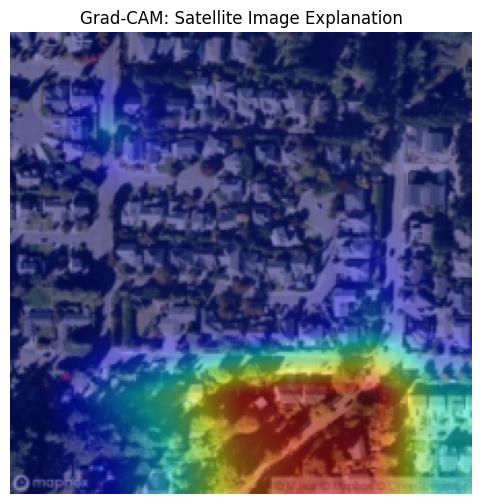

In [57]:
# ===============================
# GRAD-CAM (FINAL & CORRECT)
# ===============================

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

model.eval()

# 🔑 0️⃣ UNFREEZE last conv block (THIS FIXES EVERYTHING)
for param in model.backbone.layer4.parameters():
    param.requires_grad = True

# 1️⃣ Target layer
target_layer = model.backbone.layer4

activations = []
gradients = []

# 2️⃣ Hooks
def forward_hook(module, input, output):
    activations.append(output)
    output.retain_grad()   # IMPORTANT

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

fh = target_layer.register_forward_hook(forward_hook)
bh = target_layer.register_full_backward_hook(backward_hook)

# 3️⃣ One validation image
images, _ = next(iter(val_loader))
images = images.to(device)

# 4️⃣ Forward
embeddings = model(images)        # (B, 512)

# 🔑 Scalar target (embedding norm)
score = embeddings[0].norm()

# 5️⃣ Backward
model.zero_grad()
score.backward()

# 6️⃣ Get maps
acts  = activations[0][0]         # (C,H,W)
grads = gradients[0][0]           # (C,H,W)

# 7️⃣ Grad-CAM math
weights = grads.mean(dim=(1,2))
cam = (weights[:,None,None] * acts).sum(dim=0)
cam = F.relu(cam)

cam -= cam.min()
cam /= cam.max()

# 8️⃣ Resize
cam = cam.detach().cpu().numpy()
cam = torch.tensor(cam)[None,None]
cam = F.interpolate(cam, size=(224,224), mode="bilinear", align_corners=False)
cam = cam.squeeze().numpy()

# 9️⃣ Plot
img = images[0].detach().cpu().permute(1,2,0).numpy()
img = (img - img.min()) / (img.max() - img.min())

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(cam, cmap="jet", alpha=0.45)
plt.axis("off")
plt.title("Grad-CAM: Satellite Image Explanation")
plt.show()

# cleanup
fh.remove()
bh.remove()
